In [1]:
MEAS_COLUMNS = [
    "TI-19",
#      "FI-16",
#     "TI-33",
#     "FI-2",
#     "FI-151",
#     "TI-8",
#     "FI-241",
#  "valve-position-12",  # dry-bed
#     "FI-38",  # strippera
#     "PI-28",  # stripper
    
#     "TI-28",  # stripper
#      "FI-20",
#     "FI-30",
    "TI-3",
    "FI-19",
#     "FI-211",
    "FI-11",
#     "TI-30",
#     "PI-30",
    "TI-1213",
#     "TI-4",
#    "FI-23",
#    "FI-20",
#   "FI-20/FI-23",
#    "TI-22",
#    "delta_t",
    "TI-35",
#     "delta_t_2"
]

In [2]:
import pandas as pd 
from darts import TimeSeries

In [3]:
from pyprocessta.model.tcn import transform_data, run_model, parallelized_inference
from pyprocessta.preprocess.resample import resample_regular
from darts.dataprocessing.transformers import Scaler
import joblib

import matplotlib.pyplot as plt
plt.style.reload_library()
plt.style.use('science')
from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'

ModuleNotFoundError: No module named 'darts.utils.data.timeseries_dataset'

In [62]:
df = pd.read_pickle('20210624_df_cleaned.pkl')
#df = resample_regular(df, '5min')

In [63]:
#df.to_pickle('df_dropped_5min_resampled.pkl')

In [64]:
TARGETS_clean = ['2-Amino-2-methylpropanol C4H11NO']#['Piperazine C4H10N2'] #'2-Amino-2-methylpropanol C4H11NO',

In [65]:
y = TimeSeries.from_dataframe(df, value_cols=TARGETS_clean)
x = TimeSeries.from_dataframe(df, value_cols=MEAS_COLUMNS)

In [66]:
transformer = Scaler()
x = transformer.fit_transform(x)

y_transformer = Scaler()
y = y_transformer.fit_transform(y)

In [67]:
scal = y_transformer.transform(y)

In [118]:
model = run_model((x,y), input_chunk_length=20, output_chunk_length=5)

[2022-01-04 11:56:35,548] INFO | darts.models.torch_forecasting_model | Train dataset contains 5385 samples.
[2022-01-04 11:56:35,548] INFO | darts.models.torch_forecasting_model | Train dataset contains 5385 samples.


In [119]:
backtest = model.historical_forecasts(y,
                          covariates=x,
            
                                      start=0.1,
                          forecast_horizon=1,
                          stride=1,
                          retrain=False,
                          verbose=False)

In [97]:
import matplotlib.pyplot as plt

In [120]:
results = parallelized_inference(model, x, y, repeats=10, start=0.1, horizon=5)

In [121]:
import numpy as np 

In [122]:
def summarize_results(results): 
    values = []
    
    for df in results: 
        values.append(df.pd_dataframe().values)
    
    df = df.pd_dataframe()
    columns = df.columns
    
    return pd.DataFrame(np.mean(values, axis=0), columns=columns, index=df.index), pd.DataFrame(np.std(values, axis=0), columns=columns,  index=df.index)

In [123]:
means, stds = summarize_results(results)

In [124]:
x_axis = means['0'].index - y['0'].pd_dataframe().index[0]
x_axis = [val.total_seconds() / (60 * 60 * 24) for val in x_axis]

x_conncected = y['0'].pd_dataframe().index - y['0'].pd_dataframe().index[0]
x_conncected = [val.total_seconds() / (60 * 60 * 24) for val in x_conncected]

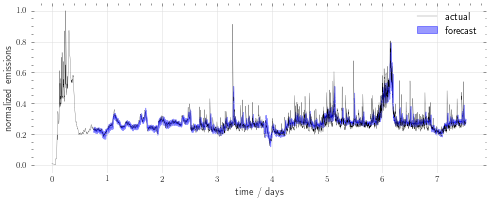

In [125]:
plt.figure(figsize=(7,3))
plt.plot(x_axis, means['0'], c='b',  alpha=.9, lw=.2)
plt.fill_between(x_axis, means['0']-2*stds['0'], means['0']+2*stds['0'], alpha=.4, color='b', label='forecast',)
plt.plot(x_conncected, y['0'].values().flatten(), c='k', label='actual', lw=.2,)

plt.legend()
#plt.xticks([])

plt.xlabel('time / days')
plt.ylabel('normalized emissions')
plt.tight_layout()
#plt.savefig(f'20211229_{TARGETS_clean[0]}_forecast_all.pdf', bbox_inches='tight')

In [42]:
# plt.figure(figsize=(7,3))
# plt.plot(x_axis, means['0'], c='b',  alpha=.9, lw=.2)
# plt.fill_between(x_axis, means['0']-2*stds['0'], means['0']+2*stds['0'], alpha=.4, color='b', label='forecast',)
# plt.plot(x_conncected, y['0'].values().flatten(), c='k', label='actual', lw=.2,)

# plt.legend()
# #plt.xticks([])

# plt.xlabel('time / days')
# plt.ylabel('normalized emissions')
# plt.tight_layout()
# plt.savefig('20210814_2_amp_forecast_all.pdf', bbox_inches='tight')

In [43]:
joblib.dump(model, f'20211229_{TARGETS_clean[0]}_model')
joblib.dump(transformer, f'20211229_{TARGETS_clean[0]}_x_scaler')
joblib.dump(y_transformer, f'20211229_{TARGETS_clean[0]}_y_scaler')

['20211229_2-Amino-2-methylpropanol C4H11NO_y_scaler']

transformero build a model for CO2 and NH3

In [52]:
NEW_TARGETS = ["Ammonia NH3"] #Carbon dioxide CO2"] #,

In [53]:
y = TimeSeries.from_dataframe(df, value_cols=NEW_TARGETS)
x = TimeSeries.from_dataframe(df, value_cols=MEAS_COLUMNS)

In [54]:
transformer = Scaler()
x = transformer.fit_transform(x)

y_transformer = Scaler()
y = y_transformer.fit_transform(y)

In [55]:
model_co2 = run_model((x,y), input_chunk_length=40, output_chunk_length=30)

[2021-12-29 21:22:06,596] INFO | darts.models.torch_forecasting_model | Train dataset contains 5340 samples.
[2021-12-29 21:22:06,596] INFO | darts.models.torch_forecasting_model | Train dataset contains 5340 samples.


In [56]:
results = parallelized_inference(model_co2, x, y, repeats=1, start=0.1, horizon=30)

In [57]:
means, stds = summarize_results(results)

In [58]:
x_axis = means['0'].index - y['0'].pd_dataframe().index[0]
x_axis = [val.total_seconds() / (60 * 60 * 24) for val in x_axis]

x_conncected = y['0'].pd_dataframe().index - y['0'].pd_dataframe().index[0]
x_conncected = [val.total_seconds() / (60 * 60 * 24) for val in x_conncected]

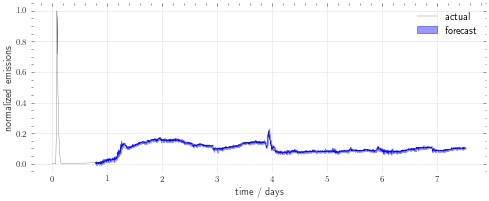

In [59]:
plt.figure(figsize=(7,3))
plt.plot(x_axis, means['0'], c='b',  alpha=.9, lw=.2)
plt.fill_between(x_axis, means['0']-2*stds['0'], means['0']+2*stds['0'], alpha=.4, color='b', label='forecast',)
plt.plot(x_conncected, y['0'].values().flatten(), c='k', label='actual', lw=.2,)

plt.legend()
#plt.xticks([])

plt.xlabel('time / days')
plt.ylabel('normalized emissions')
plt.tight_layout()
plt.savefig(f'20211229_{NEW_TARGETS[0]}_forecast_all.pdf', bbox_inches='tight')

In [60]:
joblib.dump(model_co2, f'20211229_{NEW_TARGETS[0]}_model')
#joblib.dump(transformer, f'20211229_{NEW_TARGETS[0]}_x_scaler')
joblib.dump(y_transformer, f'20211229_{NEW_TARGETS[0]}_y_scaler')

['20211229_Ammonia NH3_y_scaler']